In [1]:
import pandas as pd
from nilearn.glm.second_level import non_parametric_inference
from decouple import config
from nilearn import plotting
import numpy as np
from nilearn.reporting import get_clusters_table
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.maskers import NiftiSpheresMasker
import nibabel as nib
import matplotlib.pyplot as plt

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
path = config('happy')
files = pd.read_csv(f"{path}/1stlevel_location.csv")

In [3]:
files['group'] = files['t1'].apply(lambda participant: 0 if 'sub-G1' in participant else 1 )
files['sub'] = files.index

In [4]:
long_form = pd.melt(files, id_vars=['sub'], var_name='time_point', value_vars=['t1', 't2',], value_name='scans').sort_values(by=['sub'], ascending=True).reset_index(drop=True)
long_form['group'] = long_form['scans'].apply(lambda participants: -1 if 'sub-G1' in participants or 'sub-B1' in participants else 1 )
long_form['time'] = long_form['time_point'].apply(lambda participants: -1 if 't1' in participants else 1 )
long_form['intercept'] = 1
long_form = long_form.drop(long_form[long_form['sub'] == 75].index)

In [5]:
dummies_subjects = pd.get_dummies(long_form['sub']).add_prefix('sub-')
interaction_effect = long_form['time'] * long_form['group']

In [6]:
design_matrix = pd.concat([long_form[['intercept', 'group', 'time']], interaction_effect.rename('interaction'), dummies_subjects], axis=1) 

<AxesSubplot: label='conditions', ylabel='scan number'>

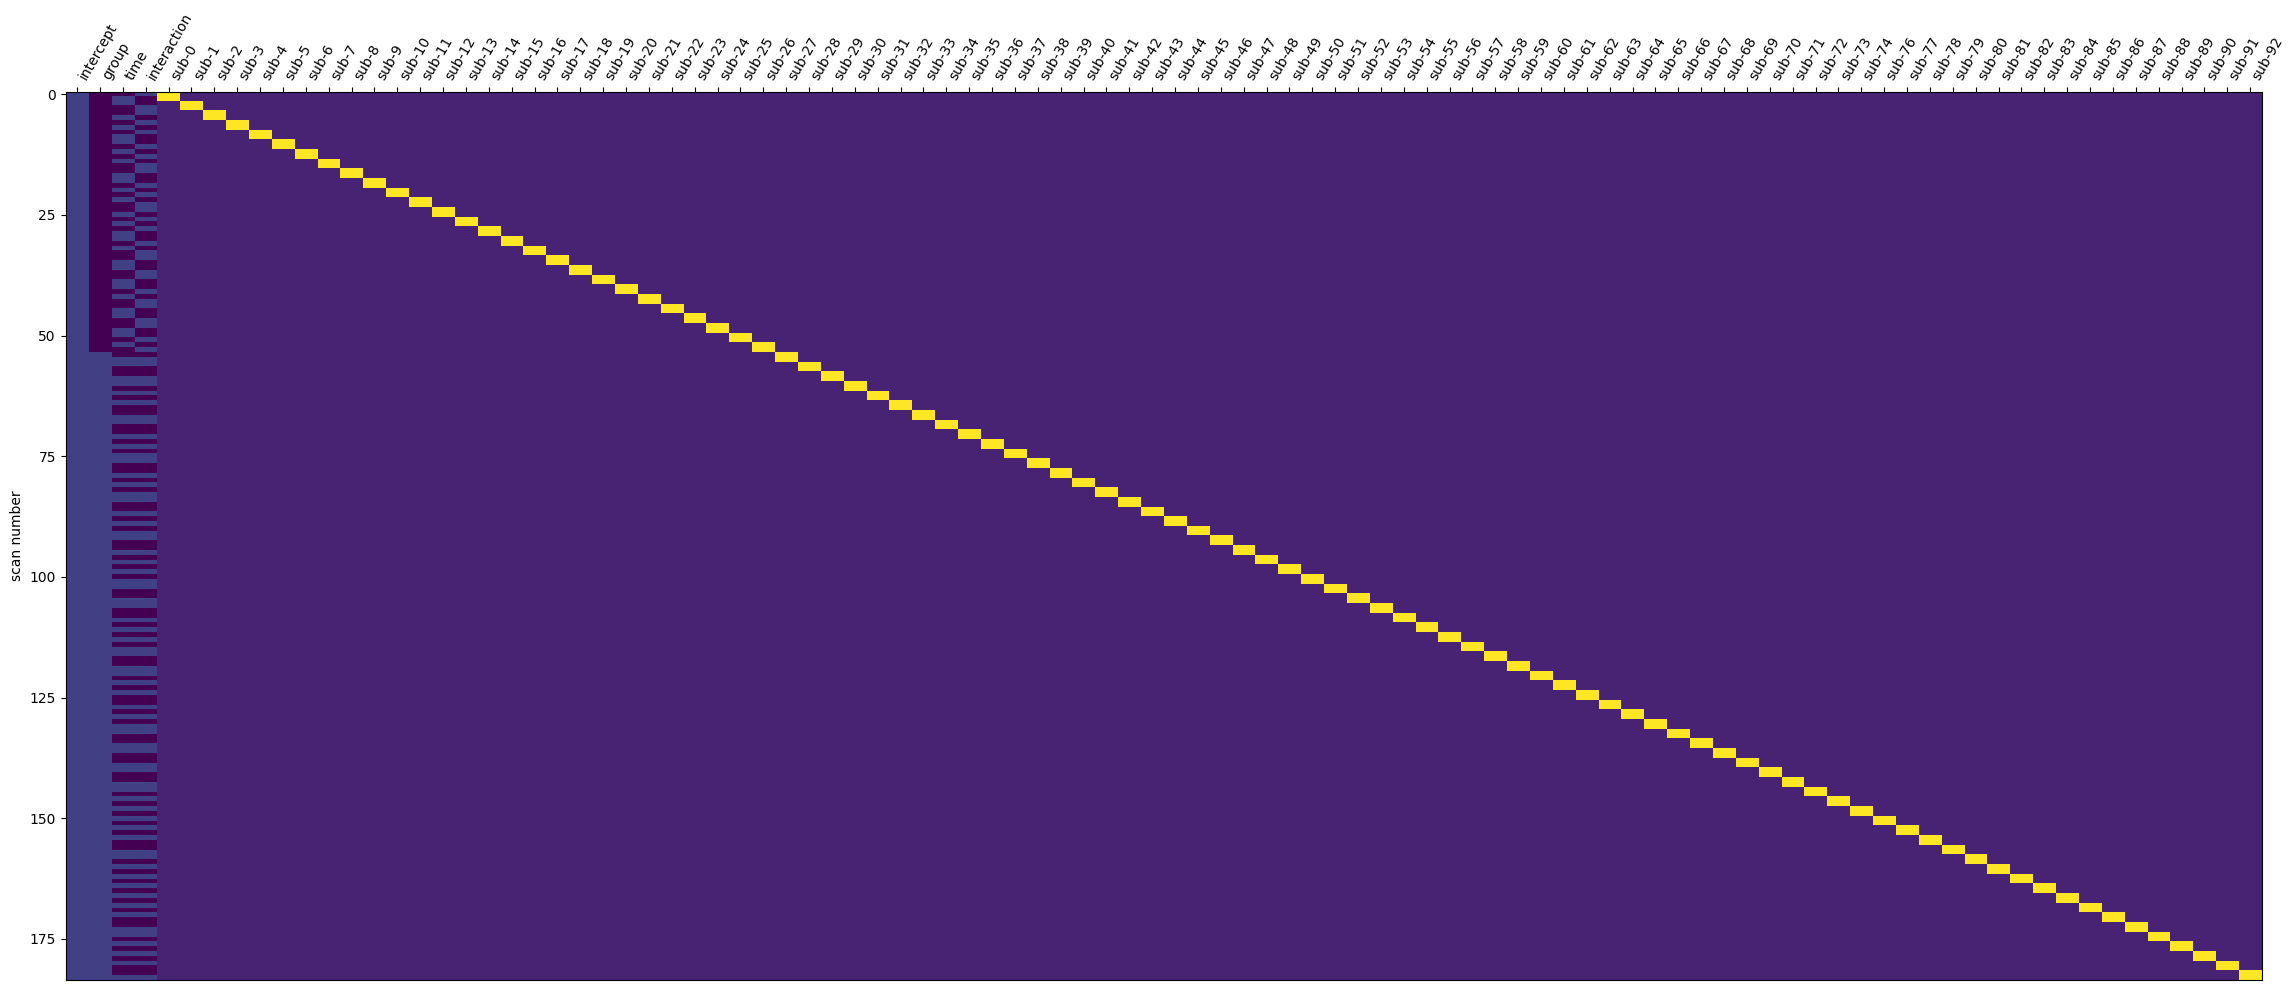

In [7]:
plotting.plot_design_matrix(design_matrix)

In [8]:
scans = long_form['scans'].to_list()

In [9]:
design_matrix.shape[0] 

184

In [10]:
random_effects_zero = np.zeros(design_matrix.shape[1] - 4).tolist()
group = [0, 1, 0,] + random_effects_zero
time = [0, 0, 1,] + random_effects_zero
interact = np.vstack([group, time])
print(interact)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
scans = long_form[long_form['scans'].str.contains('sub-B')]

In [12]:
contrasts = [contrast for contrast in design_matrix.columns if 'sub' not in contrast and 'intercept' not in contrast]
contrasts

['group', 'time', 'interaction']

In [13]:
results = non_parametric_inference(scans['scans'].to_list(), 
                         design_matrix=scans[['group','intercept']],
                         second_level_contrast='group',
                         model_intercept=True,
                         n_perm=10,
                         two_sided_test=False,
                         mask=None,
                         n_jobs=5,
                         verbose=5,
                         threshold=0.001,
                         #tfce=True
)

Fitting second level model...
Computation of second level model done in 0 seconds


[NiftiMasker.fit] Loading data from Nifti1Image(
shape=(97, 115, 97),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.fit] Computing the mask
Background mask computation
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 92),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
Job #1, processed 0/2 permutations (0.00%, 1278.1524658203125 seconds remaining)
Job #2, processed 0/2 permutations (0.00%, 1712.3889923095703 seconds remaining)
Job #3, processed 0/2 permutations (0.00%, 2120.788097381592 seconds remaining)
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.0s
Job #4, processed 0/2 permutations (0.00%, 1754.5032501220703 seconds remaining)
Job #5, processed 0/2 permutations (0.00%, 2558.8369369506836 seconds remaining)
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.6s finished
/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:960: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the 

In [14]:
print(results)

{'t': <nibabel.nifti1.Nifti1Image object at 0x7f48f91f4be0>, 'logp_max_t': <nibabel.nifti1.Nifti1Image object at 0x7f48f91f4ee0>, 'size': <nibabel.nifti1.Nifti1Image object at 0x7f48f90876d0>, 'logp_max_size': <nibabel.nifti1.Nifti1Image object at 0x7f48f902af10>, 'mass': <nibabel.nifti1.Nifti1Image object at 0x7f48f90874f0>, 'logp_max_mass': <nibabel.nifti1.Nifti1Image object at 0x7f48f902a160>}


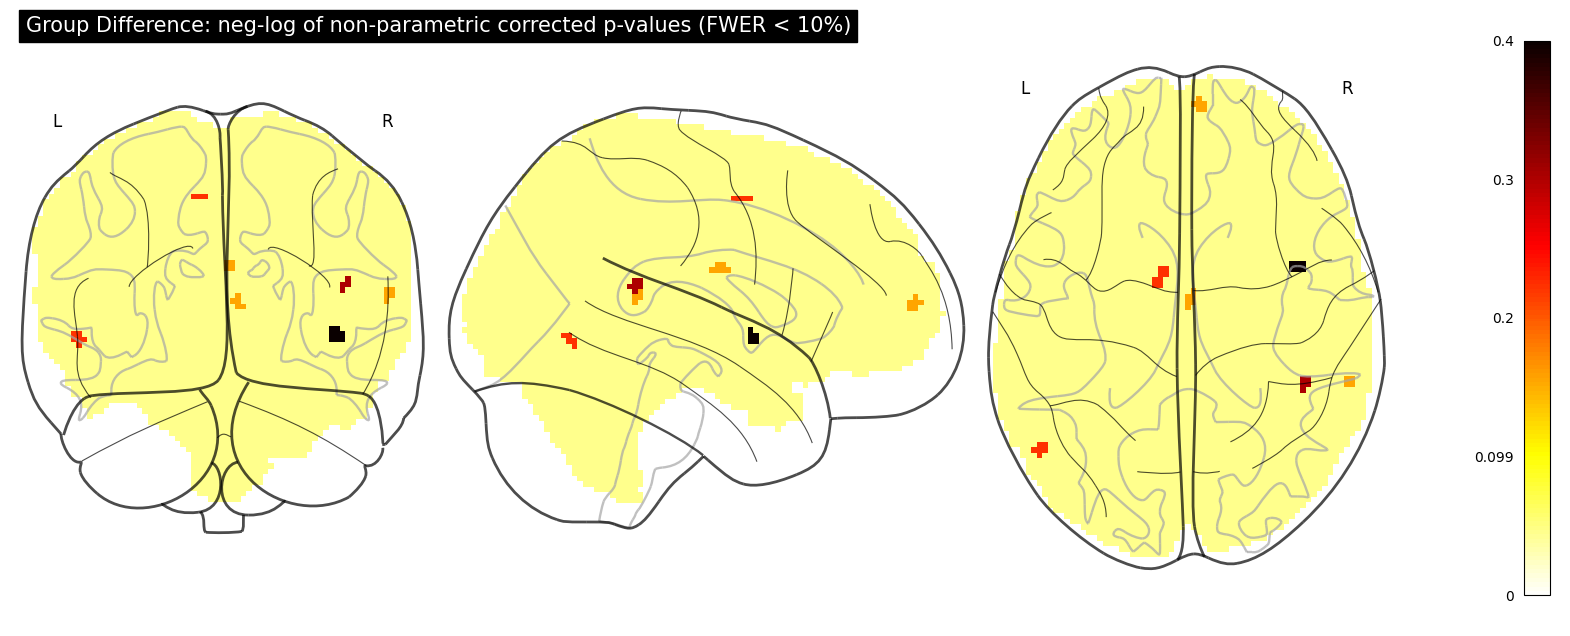

In [15]:
title = ('Group Difference: neg-log of non-parametric corrected p-values (FWER < 10%)')
fig, ax = plt.subplots(figsize=(20, 8), nrows=1, ncols=1)
plotting.plot_glass_brain(results['logp_max_mass'], colorbar=True,
                       cut_coords=[38, -17, -3], threshold=0,
                       title=title, figure=fig, axes=ax)

In [16]:
table = get_clusters_table(results['logp_max_mass'], stat_threshold=0.0,
                           cluster_threshold=00, two_sided=False).set_index('Cluster ID', drop=True)

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:103: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(


In [17]:
table = get_clusters_table(results['logp_max_t'], stat_threshold=0.0,
                           cluster_threshold=00, two_sided=False).set_index('Cluster ID', drop=True)
table.head()

,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,41.5,3.5,-0.5,0.439333,48
2,45.5,-40.5,17.5,0.439333,32
3,5.5,61.5,11.5,0.263241,8
4,-8.5,-2.5,49.5,0.196295,16
5,-52.5,-64.5,-2.5,0.087150,16


In [18]:
table.head()

,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,41.5,3.5,-0.5,0.439333,48
2,45.5,-40.5,17.5,0.439333,32
3,5.5,61.5,11.5,0.263241,8
4,-8.5,-2.5,49.5,0.196295,16
5,-52.5,-64.5,-2.5,0.087150,16
